<a href="https://colab.research.google.com/github/ahackv/mogig/blob/main/src/analysis/modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install numpy pandas scikit-learn matplotlib cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 25.9 MB/s eta 0:00:00


Simulated Data Head:
   payload_weight_kg  burst_altitude_m  wind_speed_L1_mps  wind_dir_L1_deg  \
0           0.560358      26172.485311          11.589976        50.318607   
1           0.952421      32498.262298           9.239357       323.270874   
2           1.075903      31766.888411          11.084351         2.577586   
3           2.221364      25402.319437          13.434838       138.278469   
4           1.496724      25466.823704          11.944309       142.452852   

   wind_speed_L2_mps  wind_dir_L2_deg  wind_speed_L3_mps  wind_dir_L3_deg  \
0          16.231189       219.788779          22.095788       327.591640   
1          26.913459       205.253825          21.789395       283.431884   
2          10.239901       204.129724          24.393582       313.709308   
3          26.599912       295.740271          36.423597       314.549529   
4          28.259943       271.489774          33.570911       302.271802   

   delta_lat_deg  delta_lon_deg  actual_landing

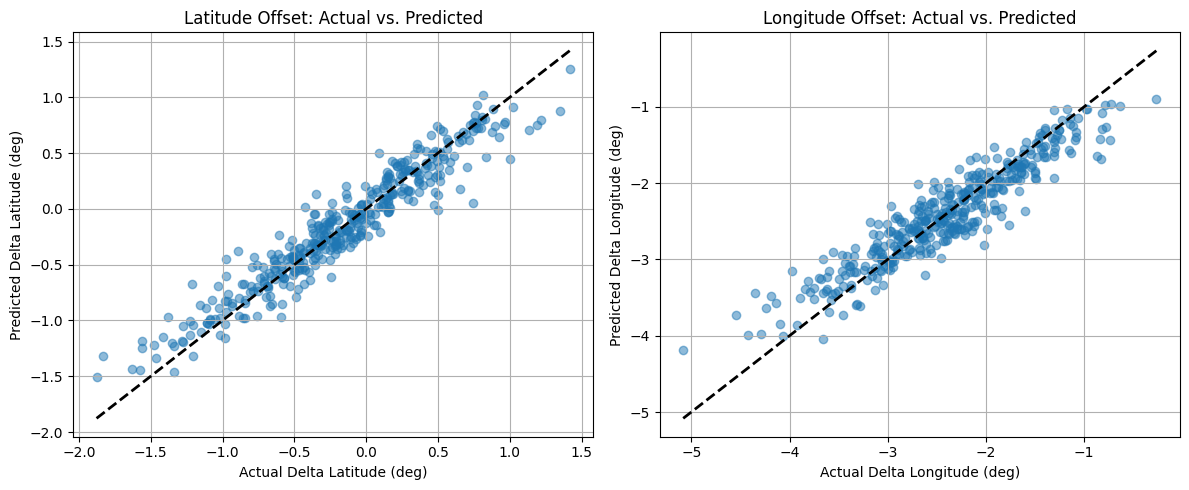

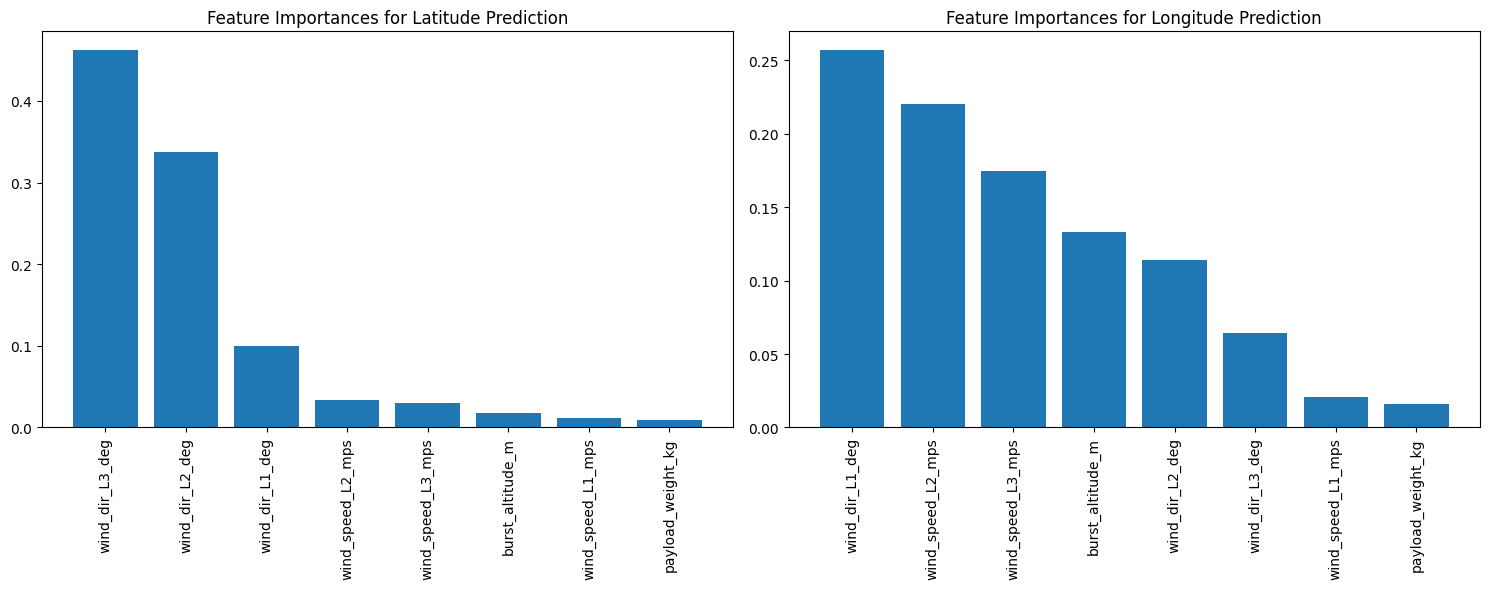

/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import cartopy.crs as ccrs # For map plotting
import cartopy.feature as cfeature

# --- 1. Simulate Data ---
def generate_simulated_data(num_samples=1000):
    """Generates simulated HAB flight data."""
    # Fixed Launch coordinates (Cambridge, UK approx)
    LAUNCH_LAT = 52.2053
    LAUNCH_LON = 0.1218

    data = []
    for _ in range(num_samples):
        # Features
        payload_weight_kg = np.random.uniform(0.5, 2.5) # kg
        burst_altitude_m = np.random.uniform(25000, 35000) # meters

        # Simplified wind model (speed in m/s, direction in degrees from North)
        # Layer 1: 0-10km, Layer 2: 10-20km, Layer 3: 20-Burst Alt
        wind_speed_L1_mps = np.random.uniform(5, 15)
        wind_dir_L1_deg = np.random.uniform(0, 360)
        wind_speed_L2_mps = np.random.uniform(10, 30)
        wind_dir_L2_deg = np.random.uniform(200, 300) # Predominantly westerly at mid-alt
        wind_speed_L3_mps = np.random.uniform(20, 50)
        wind_dir_L3_deg = np.random.uniform(230, 330) # Stronger westerly at high-alt

        # Simplified physics for landing offset calculation
        # These are not perfect physics, but create a learnable relationship
        # Heavier payload -> slightly slower ascent, slightly faster descent
        # Higher burst -> more time aloft

        # Approximate ascent/descent rates (m/s)
        # Lighter payload = faster ascent, slower descent (more drag from parachute)
        # Heavier payload = slower ascent, faster descent
        ascent_rate_mps = 5 - (payload_weight_kg * 0.5) + np.random.normal(0, 0.2)
        descent_rate_mps = 6 + (payload_weight_kg * 1.0) - (burst_altitude_m / 10000) # Higher descents are slower due to thinner air initially
        ascent_rate_mps = max(1, ascent_rate_mps) # Ensure positive
        descent_rate_mps = max(3, descent_rate_mps) # Ensure positive and reasonable

        time_to_burst_s = burst_altitude_m / ascent_rate_mps
        time_to_descend_s = burst_altitude_m / descent_rate_mps

        # Calculate drift for each layer (simplified: assume equal time proportion in active layers for drift calc)
        # This is a major simplification. Real prediction uses detailed atmospheric sounding.
        total_dx_m = 0 # Eastward displacement
        total_dy_m = 0 # Northward displacement

        # Convert wind direction (degrees from N) to vector components
        # Angle 0 is North, 90 is East. Math angle 0 is East, 90 is North.
        # So, math_angle = 90 - wind_dir_deg
        def get_dx_dy(speed, direction_deg, time_s):
            math_angle_rad = np.deg2rad(90 - direction_deg)
            dx = speed * np.cos(math_angle_rad) * time_s
            dy = speed * np.sin(math_angle_rad) * time_s
            return dx, dy

        # Ascent drift (simplified: assume 1/3 of ascent time in each 'conceptual' layer if burst is high enough)
        # A more realistic approach would integrate through altitude bands.
        # For simplicity, we'll make drift proportional to wind speed and total time.

        # Drift contribution factor (arbitrary, to make winds more impactful)
        # This is where the "magic" of the simulation happens to create a learnable pattern
        drift_factor_ascent = time_to_burst_s / 3
        drift_factor_descent = time_to_descend_s / 3

        # Layer 1 ascent & descent
        dx1_asc, dy1_asc = get_dx_dy(wind_speed_L1_mps, wind_dir_L1_deg, drift_factor_ascent * 0.8) # Lower winds affect more
        dx1_desc, dy1_desc = get_dx_dy(wind_speed_L1_mps, wind_dir_L1_deg, drift_factor_descent * 0.8)

        # Layer 2 ascent & descent
        dx2_asc, dy2_asc = get_dx_dy(wind_speed_L2_mps, wind_dir_L2_deg, drift_factor_ascent)
        dx2_desc, dy2_desc = get_dx_dy(wind_speed_L2_mps, wind_dir_L2_deg, drift_factor_descent)

        # Layer 3 ascent (descent from burst altitude is mostly in L2/L1 profile for simplicity)
        dx3_asc, dy3_asc = get_dx_dy(wind_speed_L3_mps, wind_dir_L3_deg, drift_factor_ascent * 1.2) # Higher winds stronger effect

        total_dx_m = dx1_asc + dx2_asc + dx3_asc + dx1_desc + dx2_desc
        total_dy_m = dy1_asc + dy2_asc + dy3_asc + dy1_desc + dy2_desc

        # Add some noise to make it more realistic for ML
        total_dx_m += np.random.normal(0, 5000) # +/- 5km noise
        total_dy_m += np.random.normal(0, 5000)

        # Convert meters to degrees offset (approximation: 1 deg lat ~ 111km, 1 deg lon ~ 111km * cos(lat))
        delta_lat_deg = total_dy_m / 111000
        delta_lon_deg = total_dx_m / (111000 * np.cos(np.deg2rad(LAUNCH_LAT)))

        actual_landing_lat = LAUNCH_LAT + delta_lat_deg
        actual_landing_lon = LAUNCH_LON + delta_lon_deg

        data.append({
            'payload_weight_kg': payload_weight_kg,
            'burst_altitude_m': burst_altitude_m,
            'wind_speed_L1_mps': wind_speed_L1_mps,
            'wind_dir_L1_deg': wind_dir_L1_deg,
            'wind_speed_L2_mps': wind_speed_L2_mps,
            'wind_dir_L2_deg': wind_dir_L2_deg,
            'wind_speed_L3_mps': wind_speed_L3_mps,
            'wind_dir_L3_deg': wind_dir_L3_deg,
            'delta_lat_deg': delta_lat_deg, # Target 1
            'delta_lon_deg': delta_lon_deg, # Target 2
            'actual_landing_lat': actual_landing_lat, # For plotting
            'actual_landing_lon': actual_landing_lon  # For plotting
        })
    df = pd.DataFrame(data)
    df['launch_lat'] = LAUNCH_LAT
    df['launch_lon'] = LAUNCH_LON
    return df

# --- Generate Data ---
hab_data = generate_simulated_data(num_samples=2000)
print("Simulated Data Head:")
print(hab_data.head())
print("\nSimulated Data Description:")
print(hab_data.describe())

# --- 2. Define Features (X) and Target (y) ---
# We will predict delta_lat and delta_lon separately or use a MultiOutputRegressor
# For simplicity, let's predict them as two separate targets initially.
features = [
    'payload_weight_kg', 'burst_altitude_m',
    'wind_speed_L1_mps', 'wind_dir_L1_deg',
    'wind_speed_L2_mps', 'wind_dir_L2_deg',
    'wind_speed_L3_mps', 'wind_dir_L3_deg'
]
target_lat = 'delta_lat_deg'
target_lon = 'delta_lon_deg'

X = hab_data[features]
y_lat = hab_data[target_lat]
y_lon = hab_data[target_lon]

# --- Split Data ---
X_train, X_test, y_lat_train, y_lat_test, y_lon_train, y_lon_test, data_train, data_test = train_test_split(
    X, y_lat, y_lon, hab_data[['launch_lat', 'launch_lon', 'actual_landing_lat', 'actual_landing_lon']], # Keep original lat/lon for plotting
    test_size=0.2, random_state=42
)


# --- 3. Train ML Model ---
# We'll train two separate models, one for latitude offset and one for longitude offset.
# RandomForestRegressor is a good choice.

print("\nTraining Latitude Offset Predictor...")
model_lat = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=15, min_samples_split=5)
model_lat.fit(X_train, y_lat_train)

print("Training Longitude Offset Predictor...")
model_lon = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=15, min_samples_split=5)
model_lon.fit(X_train, y_lon_train)

# --- 4. Make Predictions & Evaluate ---
y_lat_pred = model_lat.predict(X_test)
y_lon_pred = model_lon.predict(X_test)

print("\n--- Latitude Offset Prediction Evaluation ---")
mae_lat = mean_absolute_error(y_lat_test, y_lat_pred)
r2_lat = r2_score(y_lat_test, y_lat_pred)
print(f"Mean Absolute Error (Lat): {mae_lat:.4f} degrees")
print(f"R-squared (Lat): {r2_lat:.4f}")

print("\n--- Longitude Offset Prediction Evaluation ---")
mae_lon = mean_absolute_error(y_lon_test, y_lon_pred)
r2_lon = r2_score(y_lon_test, y_lon_pred)
print(f"Mean Absolute Error (Lon): {mae_lon:.4f} degrees")
print(f"R-squared (Lon): {r2_lon:.4f}")

# Convert MAE in degrees to km (approx)
# 1 deg lat ~ 111km. For lon, depends on latitude. Using launch latitude.
mae_lat_km = mae_lat * 111
mae_lon_km = mae_lon * (111 * np.cos(np.deg2rad(hab_data['launch_lat'].iloc[0])))
print(f"\nMean Absolute Error (Lat): {mae_lat_km:.2f} km")
print(f"Mean Absolute Error (Lon): {mae_lon_km:.2f} km")
print(f"Average Radial Error (approx): {np.sqrt(mae_lat_km**2 + mae_lon_km**2):.2f} km")


# --- 5. Visualize Results ---

# Store predictions with test data for easier plotting
results_df = data_test.copy()
results_df['predicted_delta_lat'] = y_lat_pred
results_df['predicted_delta_lon'] = y_lon_pred
results_df['predicted_landing_lat'] = results_df['launch_lat'] + results_df['predicted_delta_lat']
results_df['predicted_landing_lon'] = results_df['launch_lon'] + results_df['predicted_delta_lon']


# 5.1: Actual vs. Predicted Scatter Plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_lat_test, y_lat_pred, alpha=0.5)
plt.plot([y_lat_test.min(), y_lat_test.max()], [y_lat_test.min(), y_lat_test.max()], 'k--', lw=2)
plt.xlabel("Actual Delta Latitude (deg)")
plt.ylabel("Predicted Delta Latitude (deg)")
plt.title("Latitude Offset: Actual vs. Predicted")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(y_lon_test, y_lon_pred, alpha=0.5)
plt.plot([y_lon_test.min(), y_lon_test.max()], [y_lon_test.min(), y_lon_test.max()], 'k--', lw=2)
plt.xlabel("Actual Delta Longitude (deg)")
plt.ylabel("Predicted Delta Longitude (deg)")
plt.title("Longitude Offset: Actual vs. Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()


# 5.2: Feature Importances
importances_lat = model_lat.feature_importances_
indices_lat = np.argsort(importances_lat)[::-1]
feature_names = X.columns

importances_lon = model_lon.feature_importances_
indices_lon = np.argsort(importances_lon)[::-1]

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.title("Feature Importances for Latitude Prediction")
plt.bar(range(X_train.shape[1]), importances_lat[indices_lat], align="center")
plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices_lat], rotation=90)
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.title("Feature Importances for Longitude Prediction")
plt.bar(range(X_train.shape[1]), importances_lon[indices_lon], align="center")
plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices_lon], rotation=90)
plt.tight_layout()
plt.show()


# 5.3: Map Plot of Landing Predictions (using a subset for clarity)
# Ensure you have cartopy installed: pip install cartopy
num_plot_points = min(50, len(results_df)) # Plot up to 50 points
plot_subset = results_df.sample(n=num_plot_points, random_state=42)

plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Determine map extent based on launch and landing points
all_lats = pd.concat([plot_subset['launch_lat'], plot_subset['actual_landing_lat'], plot_subset['predicted_landing_lat']])
all_lons = pd.concat([plot_subset['launch_lon'], plot_subset['actual_landing_lon'], plot_subset['predicted_landing_lon']])
lat_margin = (all_lats.max() - all_lats.min()) * 0.2 + 0.5 # Add margin + fixed value for small spreads
lon_margin = (all_lons.max() - all_lons.min()) * 0.2 + 0.5
ax.set_extent([all_lons.min() - lon_margin, all_lons.max() + lon_margin,
               all_lats.min() - lat_margin, all_lats.max() + lat_margin], crs=ccrs.PlateCarree())


# Plot launch point (only one, but shown for reference with first sample)
launch_lat_plot = plot_subset['launch_lat'].iloc[0]
launch_lon_plot = plot_subset['launch_lon'].iloc[0]
ax.plot(launch_lon_plot, launch_lat_plot, 'bo', markersize=10, transform=ccrs.Geodetic(), label='Launch (Cambridge)')

# Plot actual and predicted landing points
for i, row in plot_subset.iterrows():
    # Actual landing
    ax.plot(row['actual_landing_lon'], row['actual_landing_lat'], 'go', markersize=7, alpha=0.7, transform=ccrs.Geodetic(), label='Actual Landing' if i == plot_subset.index[0] else "")
    # Predicted landing
    ax.plot(row['predicted_landing_lon'], row['predicted_landing_lat'], 'rx', markersize=7, alpha=0.7, transform=ccrs.Geodetic(), label='Predicted Landing' if i == plot_subset.index[0] else "")
    # Line from actual to predicted (error line)
    ax.plot([row['actual_landing_lon'], row['predicted_landing_lon']],
            [row['actual_landing_lat'], row['predicted_landing_lat']],
            'k--', linewidth=0.5, alpha=0.5, transform=ccrs.Geodetic())

plt.title(f'HAB Landing Predictions (Simulated Data, {num_plot_points} samples)')
plt.legend()
plt.show()

print("\n--- Script Finished ---")
print("NOTE: The simulated data and physics are highly simplified.")
print("Real-world landing prediction requires accurate atmospheric models (e.g., GFS forecasts)")
print("and more sophisticated trajectory calculation.")
print("This script demonstrates the ML workflow for such a problem.")